In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase.cluster import Decahedron

import matplotlib.pyplot as plt
from abtem import *
import cupy as cp

import dask.array as da
import dask
import os
os.environ["MKL_NUM_THREADS"] = "1"

device = 'cpu'
import numpy as np

# We need to disable the fft planning cache.
# For large fourier transforms the memory required by the cache is better utilized on increasing the batch size.

#from cupy.fft.config import get_plan_cache, show_plan_cache_info
#cache = get_plan_cache()
#cache.set_size(0)

#os.environ#["MKL_NUM_THREADS"]

current version: 1.0.0beta22


In [2]:
dask.__version__

'2021.04.0'

# STEM simulation with PRISM

STEM image with a million probe positions. Less than 1 minute per frozen phonon configuration on a single NVidia 2080 Ti GPU using the PRISM algorithm.

In [2]:
from dask.distributed import Client

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster(device_memory_limit='9GB', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60457 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
client

Client Scheduler: tcp://127.0.0.1:60458 Dashboard: http://127.0.0.1:60457/status,Cluster Workers: 1 Cores: 1 Memory: 31.93 GiB


In [4]:
device = 'cpu'

# We need to disable the fft planning cache.
# For large fourier transforms the memory required by the cache is better utilized on increasing the batch size.

from cupy.fft.config import get_plan_cache, show_plan_cache_info
cache = get_plan_cache()
cache.set_size(0)

In [5]:
p = 20
q = 3
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=5)

atoms = atoms[0:1]

In [12]:
potential = Potential(FrozenPhonons(atoms, 1, {'Au':.1}), 
                      gpts=1024,
                      device='gpu',
                      projection='infinite',
                      chunks=1,
                      precalculate=False,
                      parametrization='kirkland')


S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, chunks=30, device='gpu')
S.grid.match(potential)

S_array = S.multislice(potential)

S_array.compute()

array([[[ 1.        +0.0000000e+00j,  0.9891765 -1.4673048e-01j,
          0.95694035-2.9028469e-01j, ...,  0.90398896+4.2755589e-01j,
          0.95694464+2.9027051e-01j,  0.9891787 +1.4671542e-01j],
        [ 0.9039893 -4.2755511e-01j,  0.83146966-5.5557024e-01j,
          0.7409512 -6.7155898e-01j, ...,  1.0000001 +8.5965218e-07j,
          0.98917437-1.4674515e-01j,  0.95693594-2.9029924e-01j],
        [ 0.6343932 -7.7301049e-01j,  0.51410264-8.5772866e-01j,
          0.38268337-9.2387956e-01j, ...,  0.9039897 -4.2755437e-01j,
          0.8314613 -5.5558258e-01j,  0.7409408 -6.7157024e-01j],
        ...,
        [ 0.24302205+9.7002077e-01j,  0.38272333+9.2386299e-01j,
          0.5141398 +8.5770643e-01j, ..., -0.19504884+9.8079360e-01j,
         -0.04900976+9.9879831e-01j,  0.09807525+9.9517900e-01j],
        [ 0.6344158 +7.7299201e-01j,  0.74097073+6.7153740e-01j,
          0.8314858 +5.5554605e-01j, ...,  0.24300759+9.7002447e-01j,
          0.38272402+9.2386276e-01j,  0.5141408 

tornado.application - ERROR - Uncaught exception GET /individual-progress/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/individual-progress/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\tornado\websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\tornado\web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\bokeh\server\views\ws.py", line 140, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [8]:
from cupyx.scipy.fftpack import get_fft_plan
from cupyx.scipy.fft import fft2
#help(get_fft_plan)

cp.fft.config.enable_nd_planning = False
cache = get_plan_cache()
cache.set_size(0)

In [11]:
import dask.array as da
from abtem.basic.backend import get_array_module

from dask.graph_manipulation import checkpoint, bind


potential = Potential(FrozenPhonons(atoms, 40, {'Au':.1}), 
                      gpts=1024,
                      device='gpu',
                      projection='infinite',
                      chunks=1,
                      precalculate=False,
                      parametrization='kirkland')

S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, chunks=30, device='gpu')
S.grid.match(potential)

scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)
positions = scan.get_positions(500)

def run_config():
    from cupyx.scipy.fftpack import get_fft_plan
    import cupy as cp
    #import cupy as cp
    #from cupy.fft.config import get_plan_cache, show_plan_cache_info
    
    cp.fft.config.enable_nd_planning = False
    cache = get_plan_cache()
    cache.set_size(0)
    
    def fft(x):
        plan = get_fft_plan(a = cp.zeros((5, 1024, 1024),dtype=complex), axes=(1,2))
        return x #fft2(x, overwrite_x = True)
        
    a = da.zeros((5, 1024, 1024), chunks=(5,1024,1024), dtype=complex)
    a = a.map_blocks(cp.asarray)
    a = a.map_blocks(fft, dtype=complex, )
    #a = a.map_blocks(cp.fft.ifft2, dtype=cp.complex)
    a.compute()
    
    #cache.clear()
    
    #a = cp.fft.fft2(a)
    #S_array = S.build()#.compute()
    
#     S_array = S_array.multislice(potential)
    #S_array = S_array.downsample()
    #S_array.compute()
    
    
    
#     del S_array
#     import gc
#     gc.collect()
#     mempool = cp.get_default_memory_pool()
#     mempool.free_all_blocks()

tasks = []
for i, p in enumerate(potential.frozen_phonon_potentials()):
    

    if i > 0:
        a = bind(dask.delayed(run_config)(), a)
    else:
    #run_config(S, p)
    
        a = dask.delayed(run_config)()
    
#cp._default_memory_pool.free_all_blocks()
    
    tasks.append(a)

dask.compute(tasks)

([None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],)

In [23]:
S_array.compute()

In [9]:
positions

dask.array<rechunk-merge, shape=(311, 270, 2), dtype=float32, chunksize=(31, 31, 2), chunktype=numpy.ndarray>

In [9]:
%%time
import dask.array as da
from abtem.basic.backend import get_array_module
import cupy as cp
from dask.graph_manipulation import checkpoint, bind

potential = Potential(FrozenPhonons(atoms, 2, {'Au':.1}), 
                      gpts=1600,
                      device='gpu',
                      projection='infinite',
                      chunks=1,
                      precalculate=False,
                      parametrization='kirkland')

S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, chunks=30, device='gpu')
S.grid.match(potential)
scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)

positions = scan.get_positions(1000)

S_array = S.build()

# stack = []
# for i, p in enumerate(potential.frozen_phonon_potentials()):
    
#     S_array = S.build()
    
#     stack.append(S_array._array)

# stack = da.stack(stack)

#S_array._array = stack
def block_reduce_interpolated_S_matrix(positions, S):
    return cp.zeros((1, positions.shape[0], positions.shape[1]), dtype=cp.complex64)


array = da.zeros((8,115,1600,1600), chunks=(1,30,1600,1600))
array = array.map_blocks(cp.asarray)
reduced = da.blockwise(block_reduce_interpolated_S_matrix,
                       'qij',
                       positions, 'ijo',
                       array, 'qklm',
                       #self.wave_vectors, 'kp',
                       # adjust_chunks={  # 'k': (1,) * len(self.array.chunks[-3]),
                       #    'l': (self.interpolated_gpts[0],),
                       #    'm': (self.interpolated_gpts[1],)},
                       concatenate=True,
                       meta=cp.array((), dtype=cp.complex64))

#reduced.compute()
#S_array._array = S_array._array.map_blocks(cp.asarray)

#stack
 
#waves = S_array.reduce_by_block(positions, 1000)

#waves.array.compute()

#     #S_array._array = da.zeros((115, 1600, 1600), chunks=(30, 1600, 1600)).map_blocks(cp.asarray)
    
#     #print(S_array._array)
#     #sss
    
#     #if i > 0:
#     #    S_array._array = bind(S_array._array, image.array, split_every=False)
    
#     #S_array = S_array.multislice(p)
    
#     #S_array = S_array.downsample()
    
#     #waves = S_array
    
#     #array = S_array.array.sum()
    
#     waves = S_array.reduce_by_block(positions, 1000)
    
#     #print(waves.array)
    
#     #image = waves.diffraction_patterns().integrate_radial(50, 130)
    
#     array = waves.array
#     #array = S_array.array
    
#     stack.append(array)

# image = da.stack(stack)
#image.visualize(rankdir='LR', optimize_graph=True,)

#image.compute()

Wall time: 13 ms


<timed exec>:38: PerformanceWarning: Increasing number of chunks by factor of 32


In [12]:
#image.visualize()

In [ ]:
%%time
a = image.compute()

In [9]:
del a

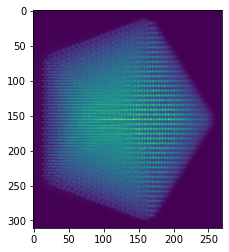

In [41]:
plt.imshow(cp.asnumpy(a.sum(0)[0]))

In [53]:
image.array.max()

array(96537864., dtype=float32)

AttributeError: 'Array' object has no attribute 'gaussian_filter'

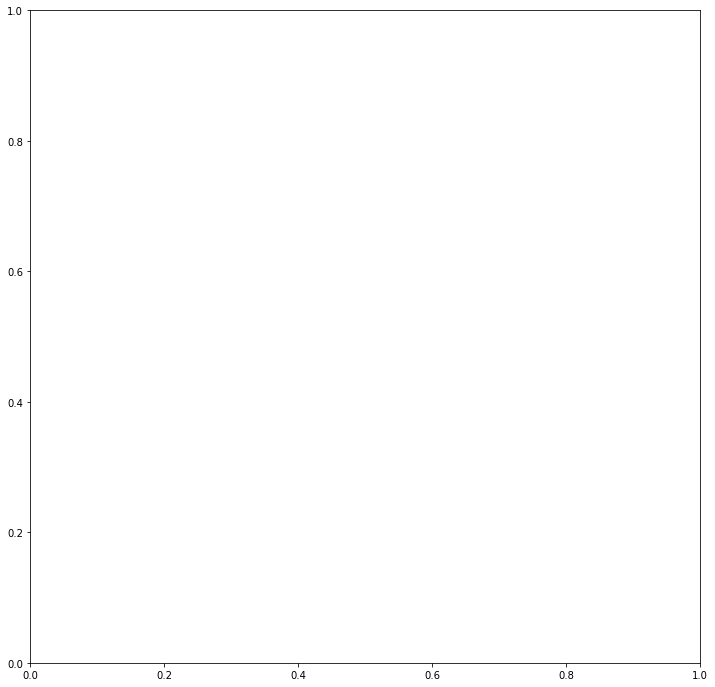

In [26]:
fig,ax=plt.subplots(figsize=(12,12))
image.gaussian_filter(.3).show(ax=ax)

In [18]:
%%time
a = image.compute(scheduler='single-threaded')

[##############################          ] | 75% Completed |  0.3s


OutOfMemoryError: Out of memory allocating 1,331,200,000 bytes (allocated so far: 10,342,400,000 bytes).

In [8]:
a.array.shape

(1, 115, 1600, 1600)

In [10]:
del a
mempool = cp.get_default_memory_pool()
cp._default_memory_pool.free_all_blocks()
mempool.free_all_blocks()

In [11]:
%%time
import dask.array as da
from abtem.basic.backend import get_array_module
import cupy as cp
from dask.graph_manipulation import checkpoint, bind

S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, chunks=200, device='gpu')
S.grid.match(potential)
scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)

stack = []
#for tds_potential in potential.frozen_phonon_potentials():
#    S_array = S.build()
    #if i > 0:
    #    S_array._array = bind(S_array._array, measurement)
    
S_array = S.multislice(potential)
    #waves = S_array.reduce_by_block(scan, 2000)
    #measurement = waves.map_blocks(cp.abs, dtype=cp.float32).sum((-2,-1)).map_blocks(cp.asnumpy)
    
#stack.append(S_array.array)

#stack = da.stack(stack)

#stack = stack.sum(0, split_every=2)
#S.compute(scheduler='single-threaded') #.visualize()

#stack.visualize()

#stack
#computed = stack.compute()

#stack.visualize()

Wall time: 27 ms


In [10]:
len(S)

115

In [10]:
20 * 12

240

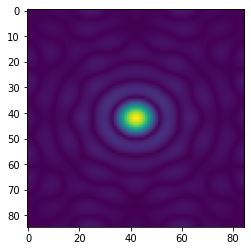

In [19]:
plt.imshow(computed[0,0])

In [21]:
%%time
import cupy as cp
import dask.array as da
from dask.graph_manipulation import checkpoint, bind


S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, chunks=58, device='gpu')
S.grid.match(potential)

stack = []
for i in range(32):
    S_build = S.build()
    if i > 0:
        S_build._array = bind(S_build._array, measurement)

    S_exit = S_build.multislice(potential)
    S_exit = S_exit.downsample()
    
    scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling*10)
    
    
    
    #waves = S_exit.reduce_by_block(scan, inner_chunks=(25,25,2), outer_chunks=(200,200,2))
    #waves = S_exit.reduce(scan, chunks=(25,25,2)).array
    #print(waves.array)
    #measurement = waves.diffraction_patterns(max_angle=None).integrate_radial(0, 30)
    #measurement = measurement.array.map_blocks(cp.asnumpy)
    
    #measurement = waves.array.map_blocks(cp.abs, dtype=cp.float32).map_blocks(cp.asnumpy)
    #waves = checkpoint
    
    #if i == 0:
    #    sums = waves
    #else:
    #    sums += waves
    
    stack.append(measurement)

stack = da.stack(stack)

#stack.dask.layers

#stack = stack.sum(0, split_every=2)




#stack.visualize(rankdir='LR')

#stack.compute()


#waves = waves.map_blocks(cp.asnumpy)
#reduced = waves.sum(0, split_every=2)
#reduced.compute()

#reduced.visualize()


dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49), dtype=complex64, chunksize=(32, 27, 56, 49), chunktype=cupy.ndarray>
dask.array<sum-aggregate, shape=(32, 27, 56, 49)

In [114]:
%%time
waves.diffraction_patterns(max_angle=None).integrate_radial(0, 10).compute()

[########################################] | 100% Completed |  2.3s
Wall time: 2.33 s


In [38]:
array

dask.array<fft2_interpolate, shape=(2, 115, 341, 295), dtype=complex64, chunksize=(1, 20, 341, 295), chunktype=cupy.ndarray>

In [15]:
measurements.array

,Array,Chunk
Bytes,2.56 MiB,400 B
Shape,"(8, 311, 270)","(1, 10, 10)"
Count,127875 Tasks,6912 Chunks
Type,float32,cupy.ndarray


In [7]:
len(S)

115

In [10]:
%%time
measurements.compute(scheduler='single-threaded')

[                                        ] | 0% Completed |  2min  5.4s


OutOfMemoryError: Out of memory allocating 409,600,000 bytes (allocated so far: 10,782,775,296 bytes).

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x268c7696100>)

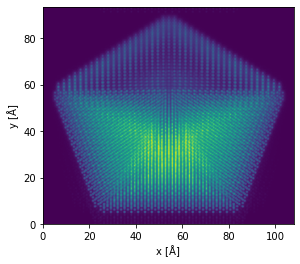

In [11]:
measurements.show()

In [34]:
#S_exit.array.visualize()

In [9]:
%%time
waves.compute(pbar=True)

Wall time: 16min 11s


In [25]:
#import os
#os.environ["MKL_NUM_THREADS"] = "12"

In [17]:
%%time
S_exit.compute(scheduler='processes', pbar=True)

Wall time: 1min 10s


array([[[ 0.4107914 -1.1844645j ,  0.59286845-1.3981453j ,
          0.5314239 -1.5501904j , ...,  0.69255435-1.094944j  ,
          0.4171309 -1.1803786j ,  0.28270167-1.1303672j ],
        [ 0.06238741-1.0298388j ,  0.1310828 -1.1952616j ,
         -0.03243293-1.3683084j , ...,  0.41042262-1.276166j  ,
          0.14232972-1.2112039j , -0.00564443-1.05539j   ],
        [-0.16445693-0.8359258j , -0.26619053-0.8031369j ,
         -0.574542  -0.8507214j , ..., -0.1450714 -1.2588991j ,
         -0.24984968-1.1390138j , -0.22939955-0.96798724j],
        ...,
        [ 1.0707903 -0.5739086j ,  1.1215287 -0.5992625j ,
          1.219068  -0.5084701j , ...,  1.3279221 +0.14550534j,
          1.2500784 -0.06048119j,  1.1350656 -0.36118987j],
        [ 1.1095808 -0.84511954j,  1.1116003 -0.8354777j ,
          1.0597302 -0.78682816j, ...,  1.1586986 -0.48383313j,
          1.1461064 -0.70036495j,  1.1185923 -0.81101394j],
        [ 0.84330434-1.1006703j ,  0.9634918 -1.2013347j ,
          0.8

In [96]:
#%%time
S_exit.compute()

Wall time: 1min 49s


array([[[ 0.5234491 -0.7601385j ,  0.36540824-0.5683793j ,
          0.19485742-0.57870436j, ...,  0.7178252 -0.76018715j,
          0.71346366-0.96420217j,  0.6473477 -0.9634046j ],
        [ 0.12798527-0.99514824j,  0.10014382-0.89736766j,
          0.05354102-0.8069278j , ...,  0.58601344-0.77600783j,
          0.41690242-0.9278166j ,  0.2332564 -1.0156645j ],
        [-0.31970412-0.88739556j, -0.3855994 -1.0054642j ,
         -0.34991977-0.99365675j, ...,  0.47246543-0.6762333j ,
          0.23331583-0.6536955j , -0.08610438-0.72807837j],
        ...,
        [ 0.8513186 +0.22030357j,  0.9345804 +0.0080575j ,
          1.0395777 -0.02261048j, ...,  0.2946023 +0.767462j  ,
          0.52376056+0.7060435j ,  0.7290563 +0.5012985j ],
        [ 0.7240899 -0.04757057j,  0.62523514-0.18763062j,
          0.6694033 -0.36306533j, ...,  0.6436144 +0.13218568j,
          0.78339446+0.07661259j,  0.82152057+0.02431762j],
        [ 0.65055376-0.3628852j ,  0.4292078 -0.31573617j,
          0.3

In [22]:
#potential.compute(pbar=True)

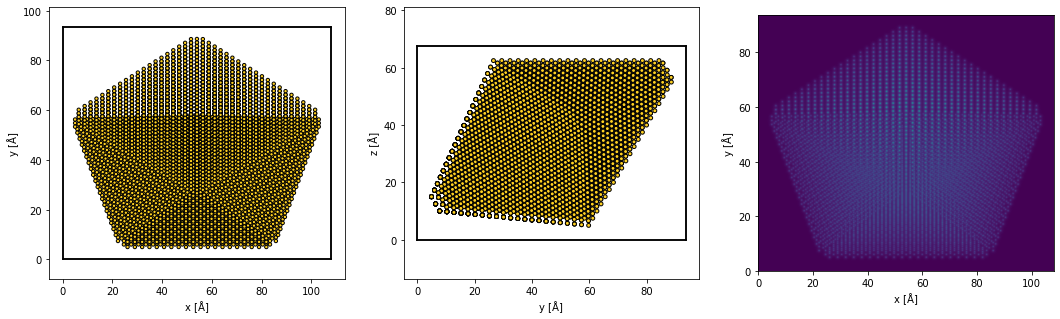

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='yz')
potential.project().show(ax=ax3, power=.5);

In [22]:
S = SMatrix(energy=80e3, expansion_cutoff=30, semiangle_cutoff=30, interpolation=12, device='cpu', storage='cpu', chunks=5)

S.grid.match(potential)

#S = S.build().compute()

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

#S.profile().show(ax=ax1);
#S.ctf.show(ax=ax2);

In [23]:
S_exit = S.multislice(potential)
S_exit = S_exit.downsample()

#scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)

#measurements = S_exit.reduce(scan, chunks=(25,25,2)).diffraction_patterns().integrate_radial(50, 150)


In [13]:
#S_exit.array.visualize()

In [24]:
%%time
S_exit.compute()

AttributeError: 'PotentialArray' object has no attribute '_generate_infinite'

In [15]:
measurements.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.core - ERROR - None
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\core.py", line 575, in handle_stream
    handler(**merge(extra, msg))
  File "C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\scheduler.py", line 5010, in client_releases_keys
    self.transitions(recommendations)
  File "C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\scheduler.py", line 7054, in transitions
    self.send_all(client_msgs, worker_msgs)
  Fil

KilledWorker: ('finalize-31371720-157d-4983-b0c1-348e7c736d54', <WorkerState 'tcp://127.0.0.1:56386', name: 0, memory: 0, processing: 1>)

distributed.nanny - WARNING - Restarting worker


In [12]:
measurements.array

dask.array<integrate_fourier_space, shape=(311, 270), dtype=float32, chunksize=(24, 25), chunktype=numpy.ndarray>

In [9]:
S_exit.array

dask.array<fft2_interpolate, shape=(115, 1365, 1183), dtype=complex64, chunksize=(115, 1365, 1183), chunktype=numpy.ndarray>

In [16]:
scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)
detector = AnnularDetector(50, 200)

measurement = S.scan(scan, detector, potential)

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x24114819be0>)

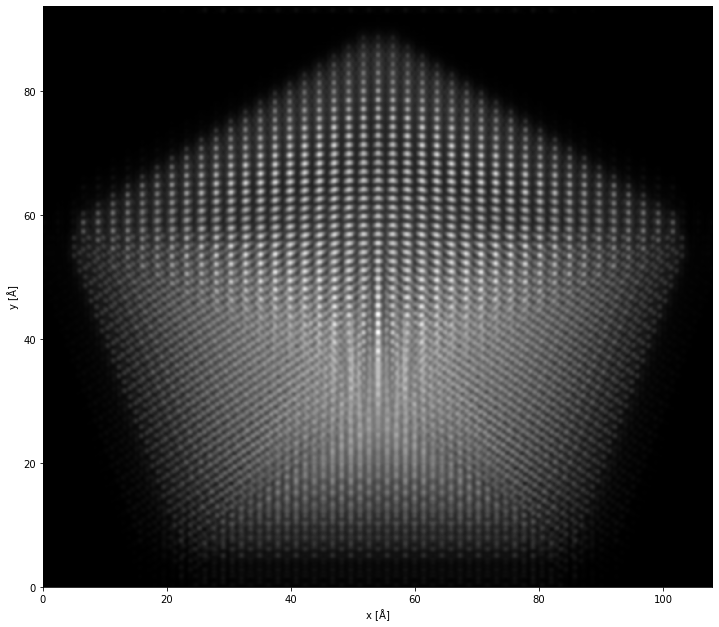

In [20]:
measurement.interpolate(.05).show(figsize=(12,12))

In [4]:
def reduce(a, b):
    return cp.zeros((1,1) + b.shape)

b = da.zeros((300,300), chunks=(20,20))

#stack = []
#for i in range(10):
    
#     substack = []
#     for i in range(10):
#         c = dask.delayed(compute_block)()
#         c = da.from_delayed(c, shape=(1, 10, 1600, 1600), dtype=float)
#         substack.append(c)
    
#     a = da.concatenate(substack, axis=1)


def new():
    return np.zeros((1, 30, 1600, 1600), dtype=np.complex64)


arrays = []
for i in range(32):
    array = []
    for j in range(4):
        c = dask.delayed(new)()
        c = da.from_delayed(c, shape=(1, 40, 1600, 1600), dtype=np.complex64)
        array.append(c)
    arrays.append(da.concatenate(array, axis=1))

a = da.concatenate(arrays)

a = da.zeros((40,115,1600,1600), chunks=(1,115,1600,1600))

a = a.map_blocks(cp.asarray)

a = da.blockwise(reduce,
                       'ijmn',
                       a, 'ijkl',
                       b, 'mn',
                       concatenate=True,
                       #adjust_chunks={  # 'k': (1,) * len(self.array.chunks[-3]),
                       #                'k': (160,),
                       #                'l': (160,)},
                       meta=cp.array((), dtype=cp.complex64))

# #a = a.sum((-2,-1))
b = a.compute()

del b
mempool = cp.get_default_memory_pool()
cp._default_memory_pool.free_all_blocks()
mempool.free_all_blocks()

#stack.append(reduced)
#reduced = da.concatenate(stack)

# import time

# def delayed_sum(a, b):
#     time.sleep(.5)
#     return cp.zeros((1, 160, 160)) #a.sum((-3, -2, -1))

# #reduced = a.sum((-2,-1), split_every=2)

# #reduced = reduced.sum(0, split_every=2)

# #a = a.map_blocks(delayed_sum, drop_axis=(2,3))
# a = da.blockwise(delayed_sum, 'ikl', a, 'ijkl', b, 'mn',
#                  concatenate=True,                         
#                  adjust_chunks={
#                                        'k': (160,),
#                                        'l': (160,)},
#                        meta=cp.array((), dtype=cp.complex64))

# a
#a = da.from_delayed(a, shape)


#reduced.visualize()

<ipython-input-4-be6cca73f931>:37: PerformanceWarning: Increasing number of chunks by factor of 40
  a = da.blockwise(reduce,


OutOfMemoryError: Out of memory allocating 2,355,200,000 bytes (allocated so far: 9,420,800,000 bytes).

distributed.utils - ERROR - 'gpu'
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\utils.py", line 668, in log_errors
    yield
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\dashboard\components\nvml.py", line 142, in update
    metrics = ws.metrics["gpu"]
KeyError: 'gpu'
bokeh.util.tornado - ERROR - Error thrown from periodic callback:
bokeh.util.tornado - ERROR - Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\tornado\gen.py", line 526, in callback
    result_list.append(f.result())
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\bokeh\server\session.py", line 195, in with_document_locked
    return func(*args, **kwargs)
  F